In [78]:
import queue
from experiment_information import *
from experiments.sweep_generalization_error import *
from data import *
from _version import __version__
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of experiments.sweep_generalization_error failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/kasimirtanner/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Bildung/Studium_Physik_EPFL/Semester 4/TP IV/TPIV---Logistic-Classification/experiments/sweep_

In [79]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_erm = dbHandler.get_erms()
    # delete incomplete experiments (bad, deletes running experiments...)
    dbHandler.delete_incomplete_experiments()
print("Current code version, ", __version__)

Current code version,  16


In [80]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "13"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(2)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,tau,d,erm_methods,completed
33,1b761ade-9cfc-4637-a386-e55856e4264f,Default Experiment,93.367661,16,2023-04-02 14:02:32,1,3,"[0.2, 2.0, 5.0]",[0],"[0.0, 0.001, 1.0]",0.0,500,"[""logistic"", ""sklearn""]",1
28,7969694c-caa0-4fff-b667-76ca901bab2e,Default Experiment,130.310576,16,2023-04-01 11:09:11,1,3,"[0.2, 2.0, 5.0]","[0.0, 0.15]",[1],0.0,500,"[""gd"", ""L-BFGS-B""]",1


In [81]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)

1b761ade-9cfc-4637-a386-e55856e4264f


In [88]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes
df = state_evolution.join(gd)
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm']]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std])
# display all columns
pd.set_option('display.max_columns', None)
df

generalization_error_state_evolution       \
                                                        mean  std   
alpha epsilon tau lam                                               
0.2   0.0     0.0 0.001                             0.387248  0.0   
                  1.000                             0.388832  0.0   
2.0   0.0     0.0 0.001                             0.177627  0.0   
                  1.000                             0.205150  0.0   
5.0   0.0     0.0 0.001                             0.084815  0.0   
                  1.000                             0.124055  0.0   

                        generalization_error_erm_erm            \
                                                mean       std   
alpha epsilon tau lam                                            
0.2   0.0     0.0 0.001                     0.387507  0.011330   
                  1.000                     0.387073  0.020965   
2.0   0.0     0.0 0.001                     0.181740  0.004320   
                  1.000                     0.199203  0.004296   
5.0   0.0     0.0 0.001                     0.087977  0.004911   
                  1.000                     0.122057  0.004189   

                        generalization_error_overlap_erm            \
                                                    mean       std   
alpha epsilon tau lam                                                
0.2   0.0     0.0 0.001                         0.388808  0.011046   
                  1.000                         0.387904  0.018961   
2.0   0.0     0.0 0.001                         0.181392  0.003628   
                  1.000                         0.199373  0.003937   
5.0   0.0     0.0 0.001                         0.088203  0.004271   
                  1.000                         0.121792  0.003050   

                        sigma_state_evolution      q_state_evolution       \
                                         mean  std              mean  std   
alpha epsilon tau lam                                                       
0.2   0.0     0.0 0.001            840.486739  0.0          5.637765  0.0   
                  1.000              0.962750  0.0          0.032955  0.0   
2.0   0.0     0.0 0.001            211.945263  0.0         67.551886  0.0   
                  1.000              0.725744  0.0          0.379528  0.0   
5.0   0.0     0.0 0.001             54.925751  0.0        179.446039  0.0   
                  1.000              0.528706  0.0          1.021613  0.0   

                              Q_erm           m_state_evolution       \
                               mean       std              mean  std   
alpha epsilon tau lam                                                  
0.2   0.0     0.0 0.001    5.781199  0.194046          0.823586  0.0   
                  1.000    0.032369  0.001845          0.062119  0.0   
2.0   0.0     0.0 0.001   67.006908  1.716646          6.972172  0.0   
                  1.000    0.377653  0.006936          0.492479  0.0   
5.0   0.0     0.0 0.001  171.776935  6.551260         12.923014  0.0   
                  1.000    1.027173  0.012351          0.934955  0.0   

                             m_erm           cosb_state_evolution       \
                              mean       std                 mean  std   
alpha epsilon tau lam                                                    
0.2   0.0     0.0 0.001   0.840983  0.093564             0.346861  0.0   
                  1.000   0.061233  0.006748             0.342189  0.0   
2.0   0.0     0.0 0.001   6.982925  0.152147             0.848300  0.0   
                  1.000   0.471364  0.021641             0.799402  0.0   
5.0   0.0     0.0 0.001  12.536612  0.269743             0.964710  0.0   
                  1.000   0.908737  0.021131             0.925012  0.0   

                         cosb_erm             rho_erm            
                             mean       std      mean       std  
alpha epsilon tau lam             

<AxesSubplot: xlabel='alpha,tau,lam'>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


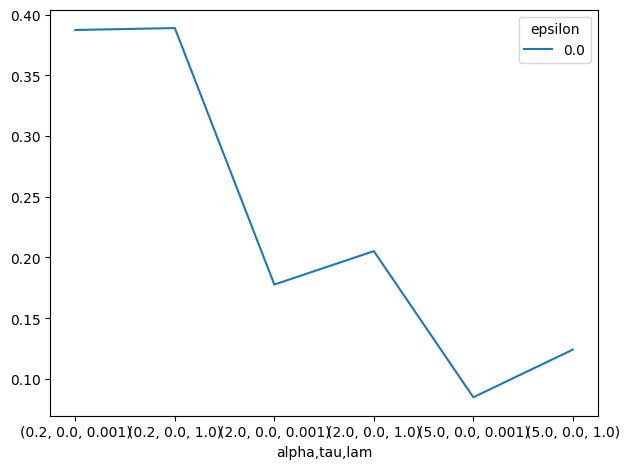

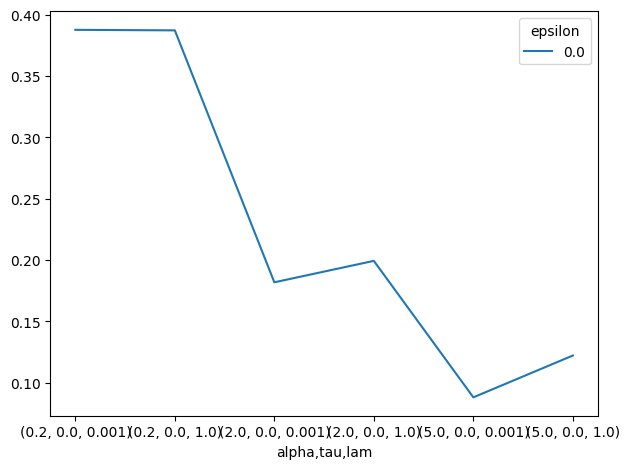

In [89]:
# plot generalization_error_state_evolution vs alpha
df["generalization_error_state_evolution"]["mean"].unstack(level=1).plot()
df["generalization_error_erm_erm"]["mean"].unstack(level=1).plot()

In [84]:
# Create a SweepExperiment
experiment = get_default_experiment()
# use json dump to save the experiment parameters
with open("sweep_experiment.json","w") as f:
    # use the NumpyEncoder to encode numpy arrays
    json.dump(experiment.__dict__,f,cls=NumpyEncoder)